In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#Spark session
spark = SparkSession.builder.appName("AgriculturalYieldPrediction").getOrCreate()

#dataset
train_df = spark.read.csv("hdfs://localhost:9000/datasets/agricultural_yield_train.csv", header=True)


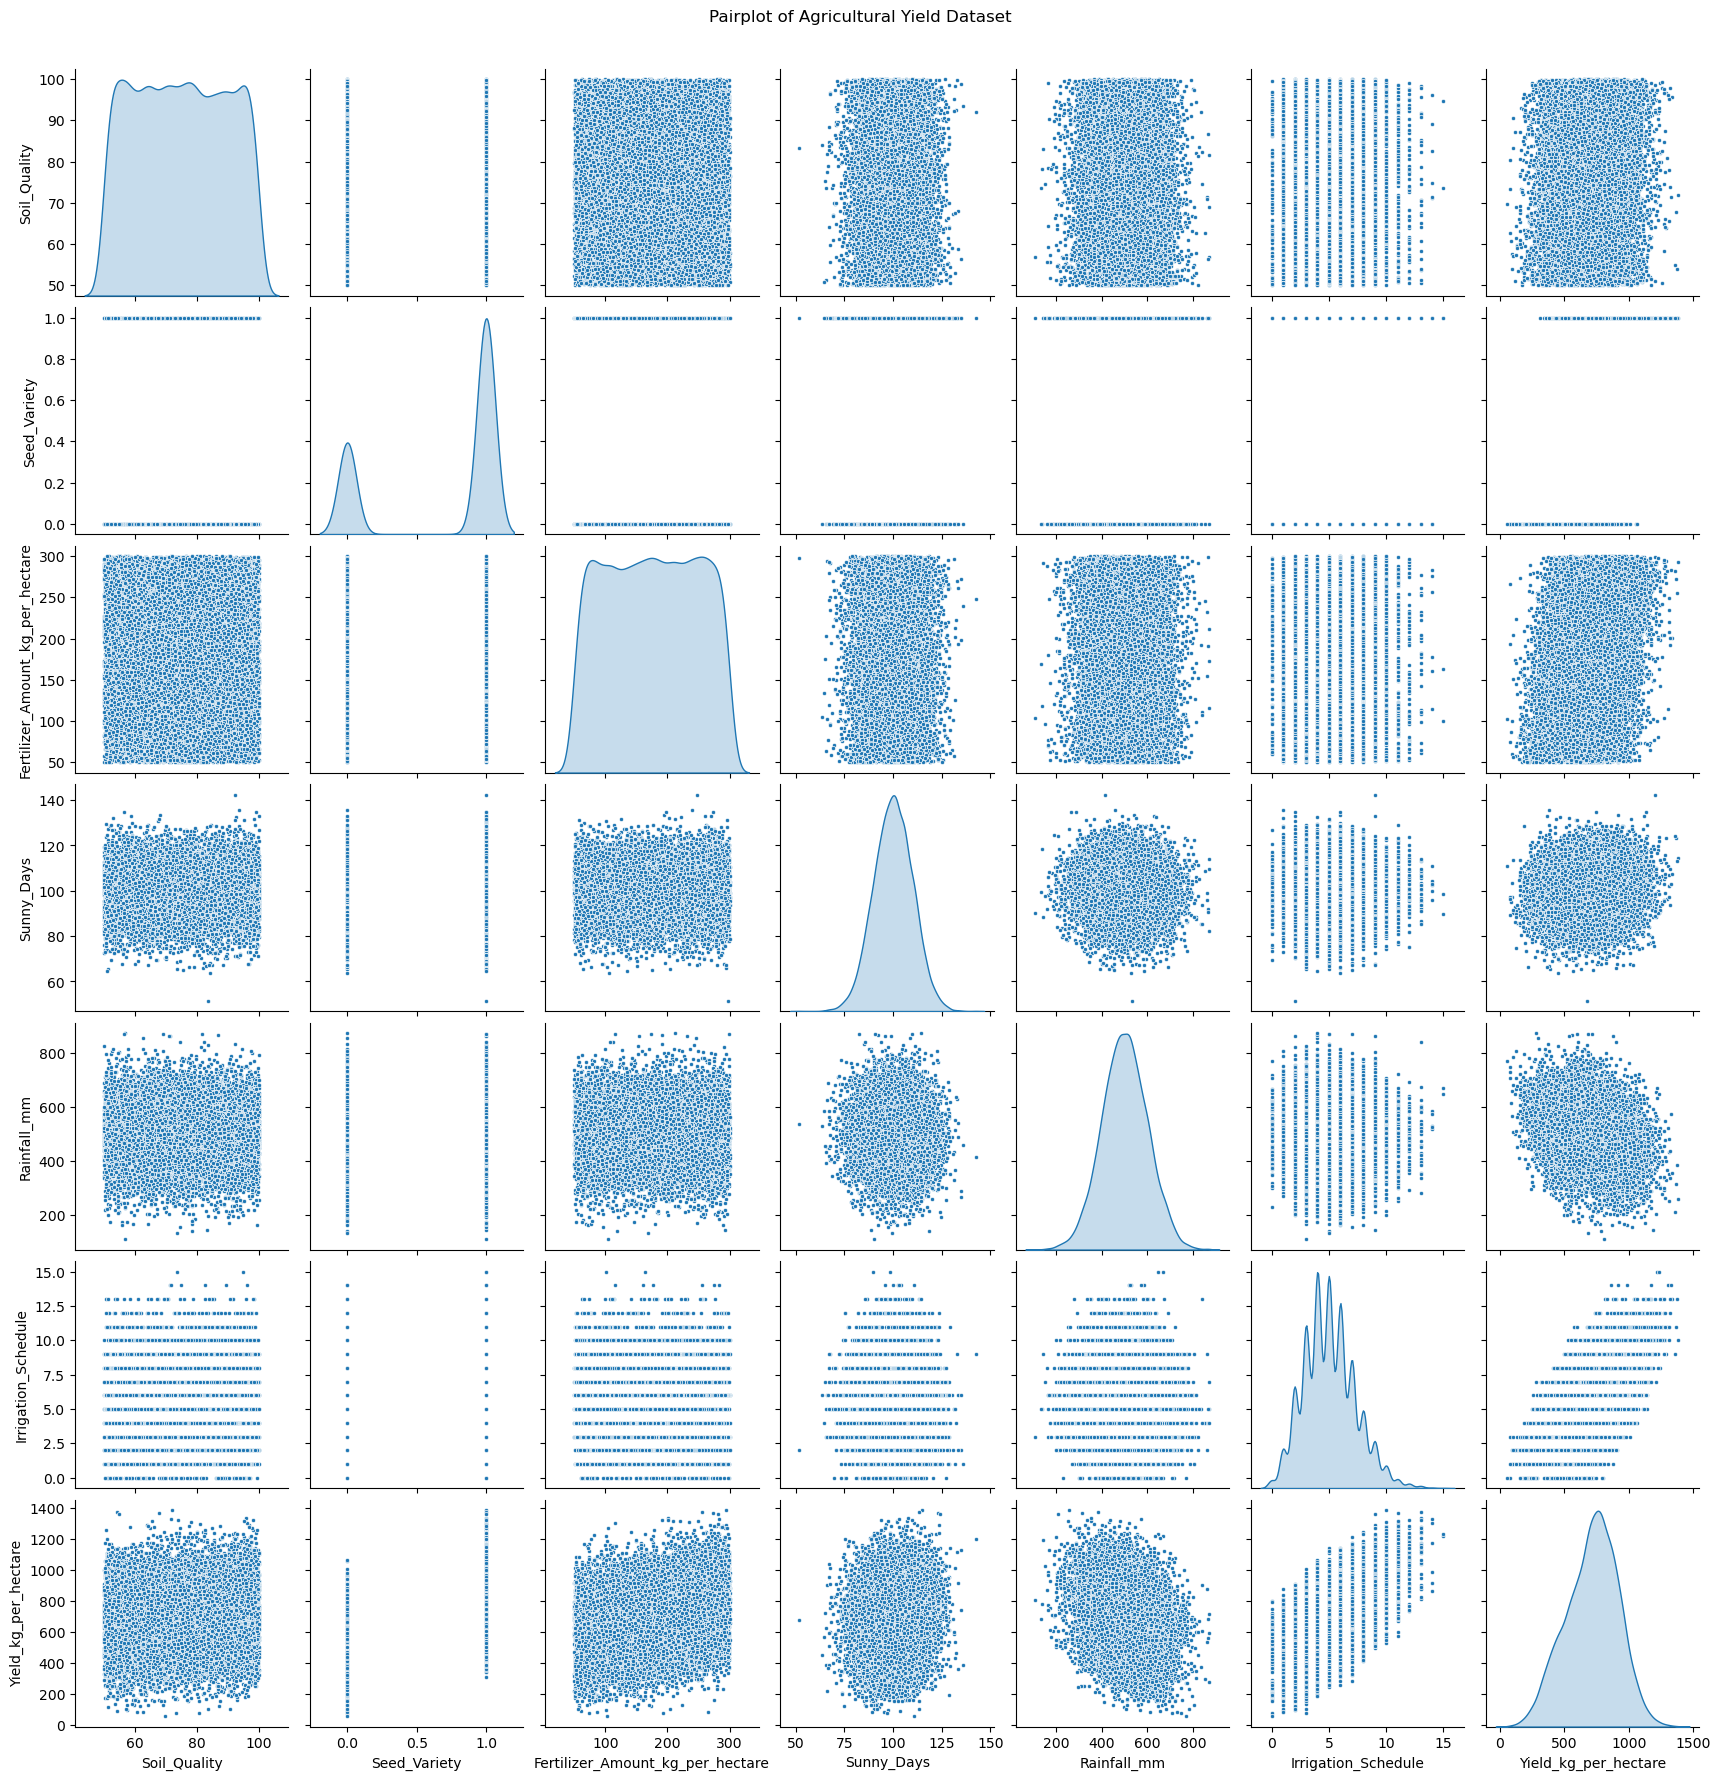

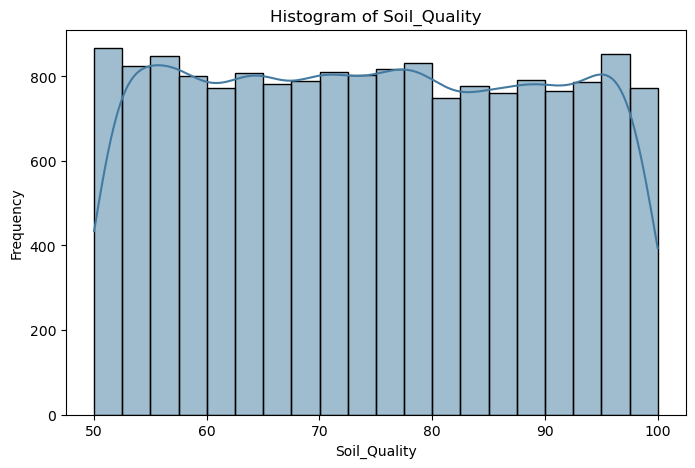

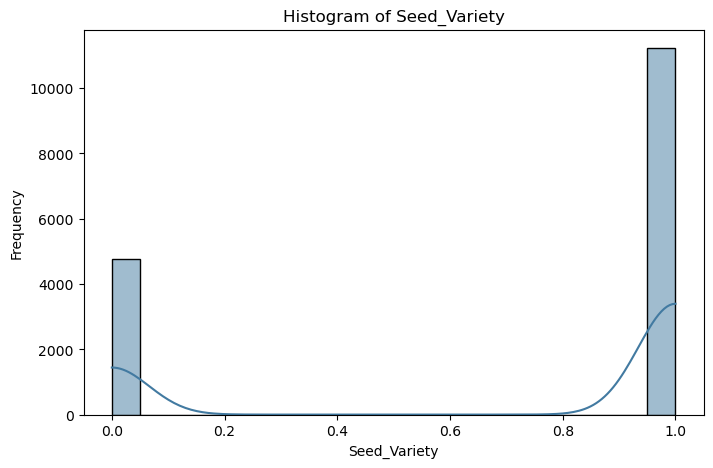

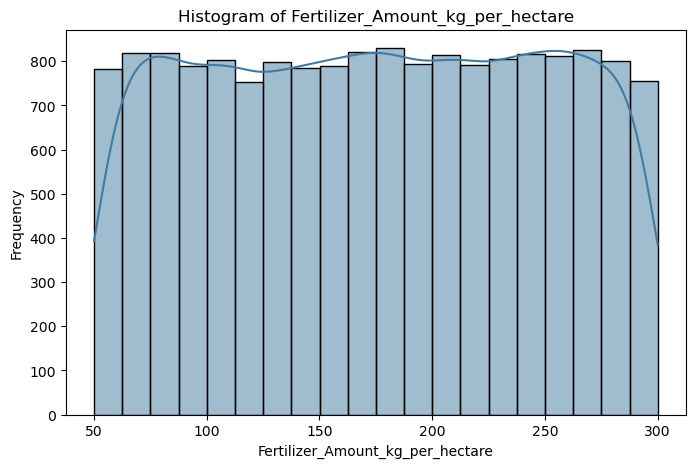

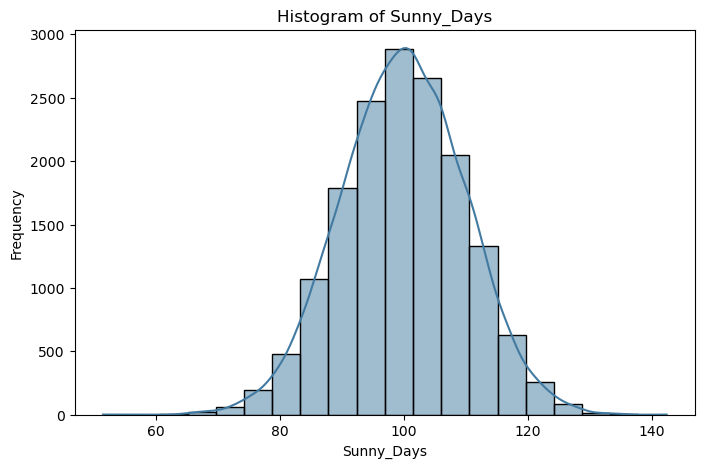

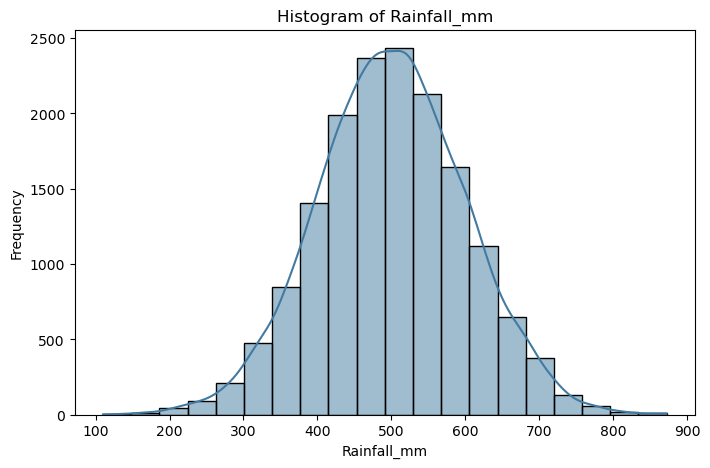

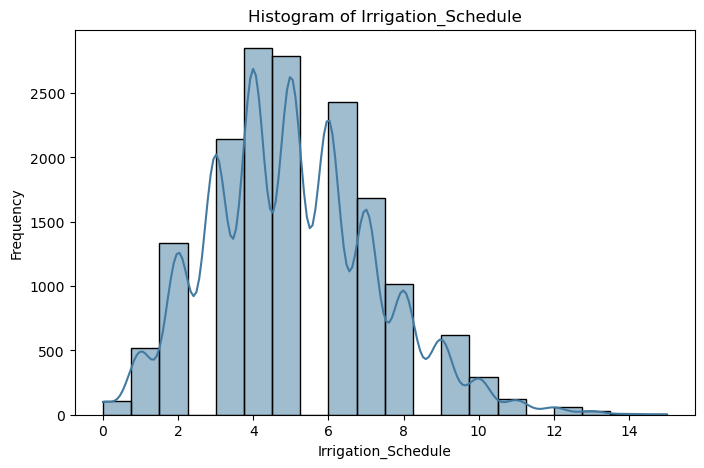

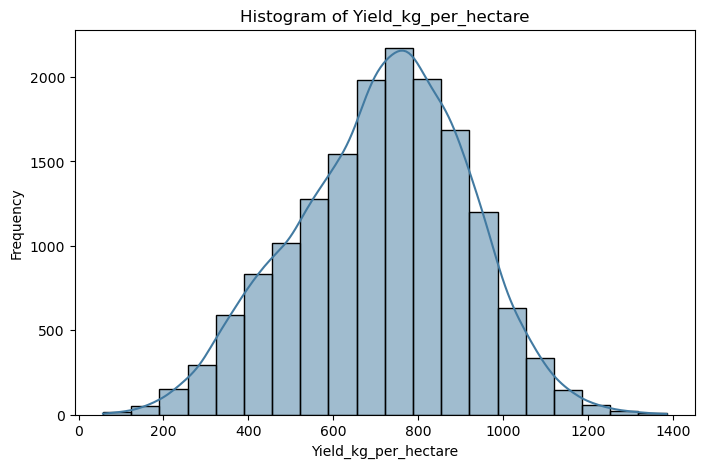

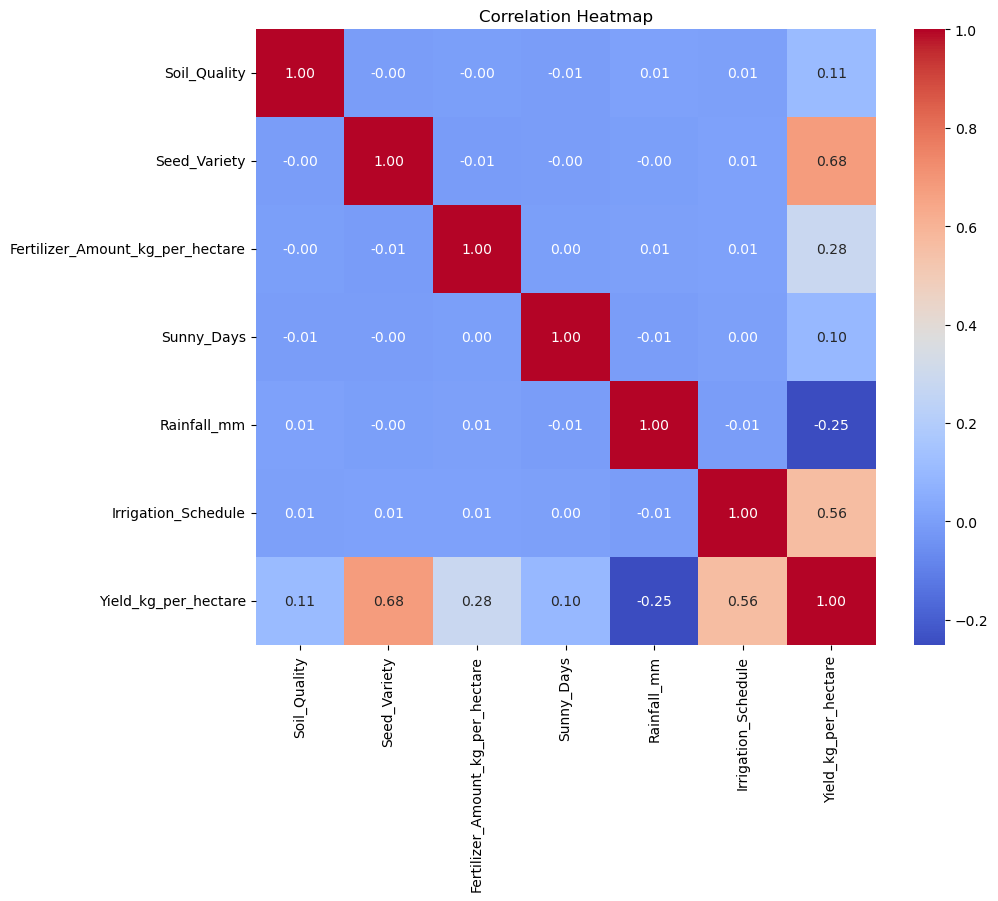

In [2]:
#data visualization
selected_features = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare',
                      'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule', 'Yield_kg_per_hectare']
df = train_df.select(selected_features)

for column in df.columns:
    df = df.withColumn(column, df[column].cast('double'))

df_pd = df.toPandas()

sns.pairplot(df_pd, diag_kind='kde', markers='.',)
plt.suptitle("Pairplot of Agricultural Yield Dataset", y=1.02)
plt.show()

for feature in selected_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_pd[feature], kde=True, color='#427AA1', bins=20)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

correlation_matrix = df_pd.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()





Results for 1000 Rows:
Root Mean Squared Error (RMSE) on test data: 48.68371190929638
Mean Absolute Error (MAE) on test data: 39.10228288195958
R-squared (R2) on test data: 0.939322676295877
Execution Time: 0.2998642921447754 seconds



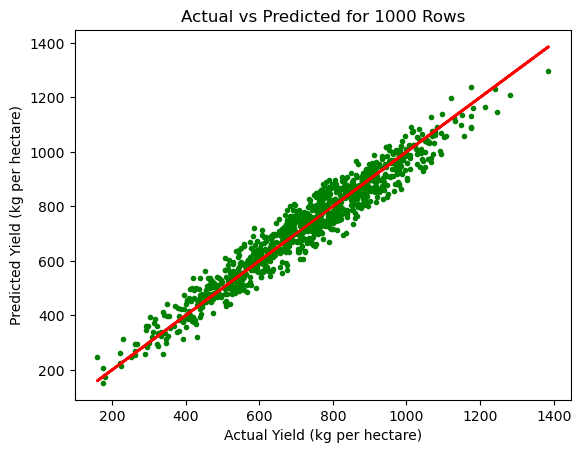


Results for 5000 Rows:
Root Mean Squared Error (RMSE) on test data: 49.8899346932957
Mean Absolute Error (MAE) on test data: 39.93491221253892
R-squared (R2) on test data: 0.9389857850821209
Execution Time: 0.3679389953613281 seconds



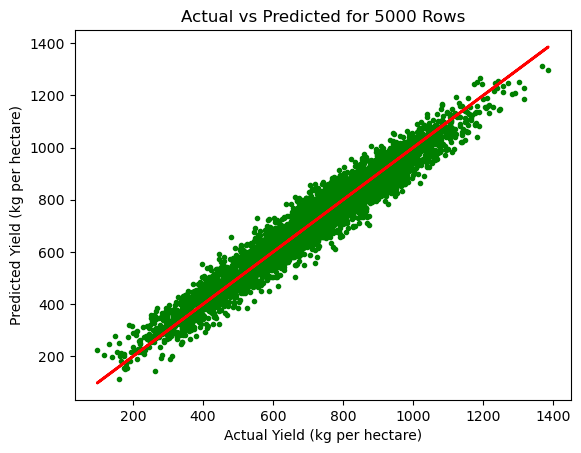


Results for 10000 Rows:
Root Mean Squared Error (RMSE) on test data: 49.82700921026998
Mean Absolute Error (MAE) on test data: 39.875819030762834
R-squared (R2) on test data: 0.9388423534310305
Execution Time: 0.380462646484375 seconds



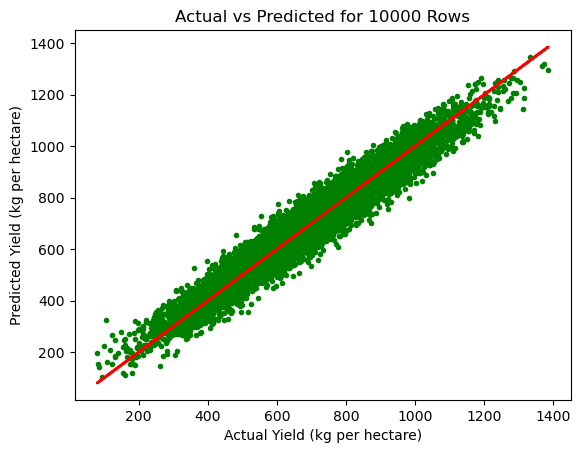


Results for 16000 Rows:
Root Mean Squared Error (RMSE) on test data: 50.051386581419294
Mean Absolute Error (MAE) on test data: 40.06283718688177
R-squared (R2) on test data: 0.938729674504097
Execution Time: 0.464235782623291 seconds



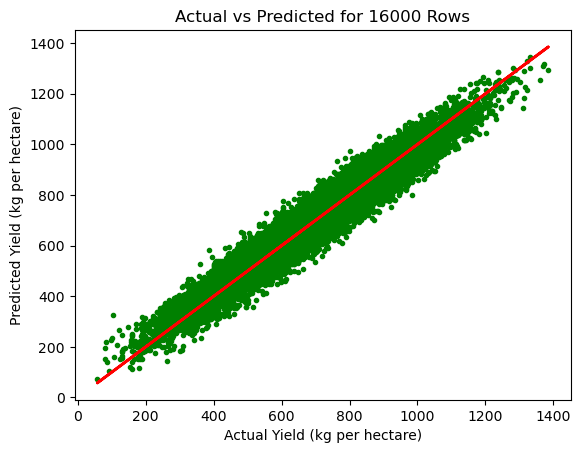

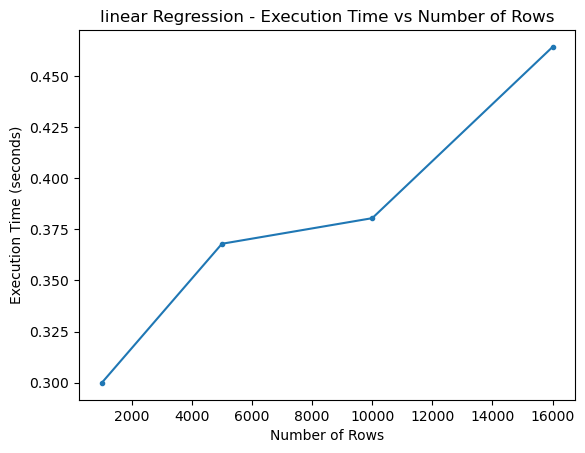

In [4]:
#linear model
# Select relevant columns for the model
selected_columns = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare',
                     'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule', 'Yield_kg_per_hectare']
train_df_selected = train_df.select(selected_columns)

# Convert columns to numeric data type
for column in train_df_selected.columns:
    train_df_selected = train_df_selected.withColumn(column, col(column).cast('double'))

# Create a feature vector
vector_assembler = VectorAssembler(inputCols=selected_columns[:-1], outputCol='features_temp')
train_df_assembled = vector_assembler.transform(train_df_selected)
train_df_assembled = train_df_assembled.withColumnRenamed('features_temp', 'features')

# Vary the number of rows for testing
num_rows_values = [1000, 5000, 10000, 16000]

# Lists to store results
rmse_values = []
mae_values = []
r2_values = []
training_times = []

for num_rows_to_read in num_rows_values:
    # Limit the number of rows to read
    sampled_data = train_df_assembled.limit(num_rows_to_read)

    # Create a Linear Regression model
    lr = LinearRegression(featuresCol='features', labelCol='Yield_kg_per_hectare')

    # Create a pipeline
    pipeline = Pipeline(stages=[vector_assembler, lr])

    # Start timing
    start_time = time.time()

    # Train the model
    model = pipeline.fit(sampled_data)

    # End timing
    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    training_times.append(training_time)

    print(f'\nResults for {num_rows_to_read} Rows:')
    
    # Make predictions on the test data
    predictions = model.transform(sampled_data)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol='Yield_kg_per_hectare', predictionCol='prediction', metricName='rmse')
    rmse = evaluator.evaluate(predictions)
    rmse_values.append(rmse)
    print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')

    # Additional evaluation metrics
    mae_evaluator = RegressionEvaluator(labelCol='Yield_kg_per_hectare', predictionCol='prediction', metricName='mae')
    mae = mae_evaluator.evaluate(predictions)
    mae_values.append(mae)
    print(f'Mean Absolute Error (MAE) on test data: {mae}')

    # R-squared (coefficient of determination)
    r2_evaluator = RegressionEvaluator(labelCol='Yield_kg_per_hectare', predictionCol='prediction', metricName='r2')
    r2 = r2_evaluator.evaluate(predictions)
    r2_values.append(r2)
    print(f'R-squared (R2) on test data: {r2}')
    
    print(f'Execution Time: {training_time} seconds\n')

    # Plotting
    plt.scatter(predictions.select('Yield_kg_per_hectare').collect(), predictions.select('prediction').collect(), marker='.',color='g')
    plt.plot(predictions.select('Yield_kg_per_hectare').collect(), predictions.select('Yield_kg_per_hectare').collect(), color='red', linewidth=2)
    plt.title(f'Actual vs Predicted for {num_rows_to_read} Rows')
    plt.xlabel('Actual Yield (kg per hectare)')
    plt.ylabel('Predicted Yield (kg per hectare)')
    plt.show()

# Plot Exucution time vs number of rows
plt.plot(num_rows_values, training_times, marker='.')
plt.title('linear Regression - Execution Time vs Number of Rows')
plt.xlabel('Number of Rows')
plt.ylabel('Execution Time (seconds)')
plt.show()


Results for Random Forest Regression and 1000 Rows:
Training Time: 0.3727743625640869 seconds
Root Mean Squared Error (RMSE) on test data: 74.8221087693349
Mean Absolute Error (MAE) on test data: 59.37444944907014
R-squared (R2) on test data: 0.8566759942479416



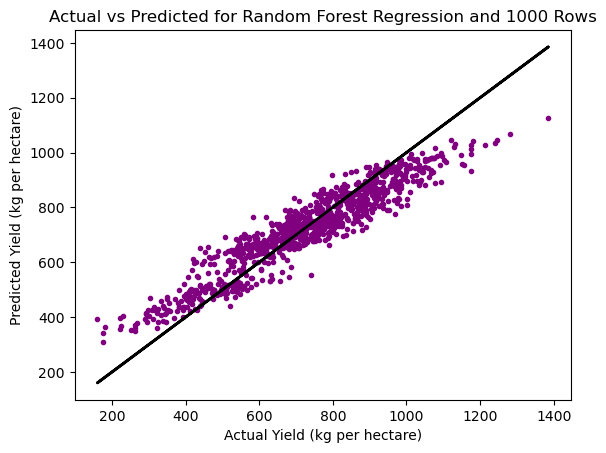


Results for Random Forest Regression and 5000 Rows:
Training Time: 0.4956650733947754 seconds
Root Mean Squared Error (RMSE) on test data: 79.41645358841154
Mean Absolute Error (MAE) on test data: 62.87408932354768
R-squared (R2) on test data: 0.8453940743408759



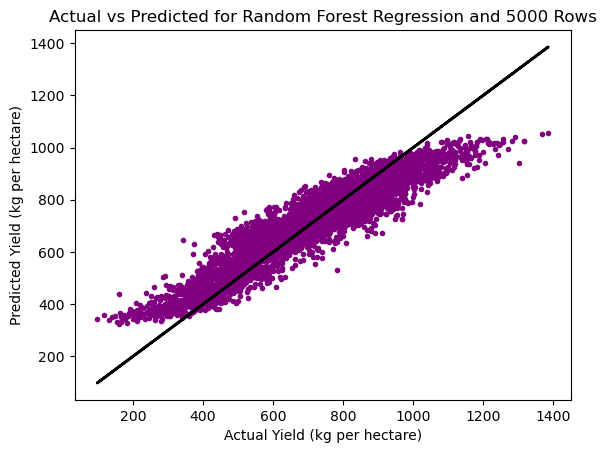


Results for Random Forest Regression and 10000 Rows:
Training Time: 0.673945426940918 seconds
Root Mean Squared Error (RMSE) on test data: 80.35578804087245
Mean Absolute Error (MAE) on test data: 63.33079048809844
R-squared (R2) on test data: 0.8409420233072136



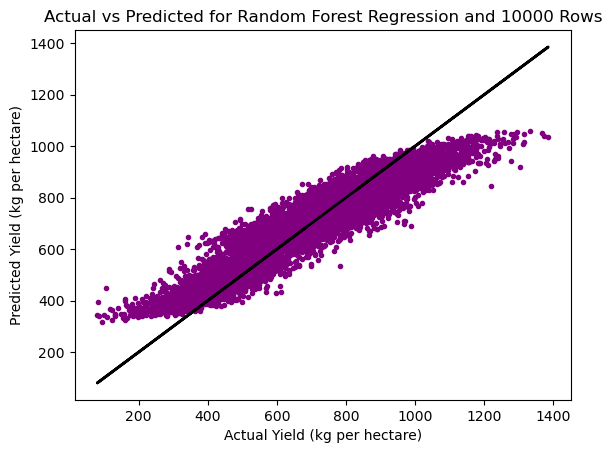


Results for Random Forest Regression and 16000 Rows:
Training Time: 0.8092188835144043 seconds
Root Mean Squared Error (RMSE) on test data: 81.04491345548693
Mean Absolute Error (MAE) on test data: 63.868106360687804
R-squared (R2) on test data: 0.839354158973222



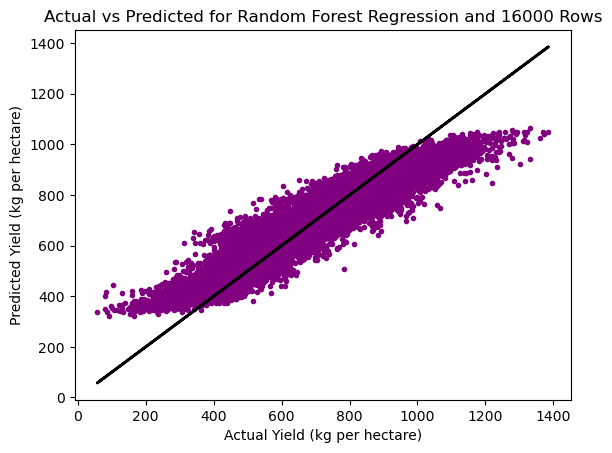

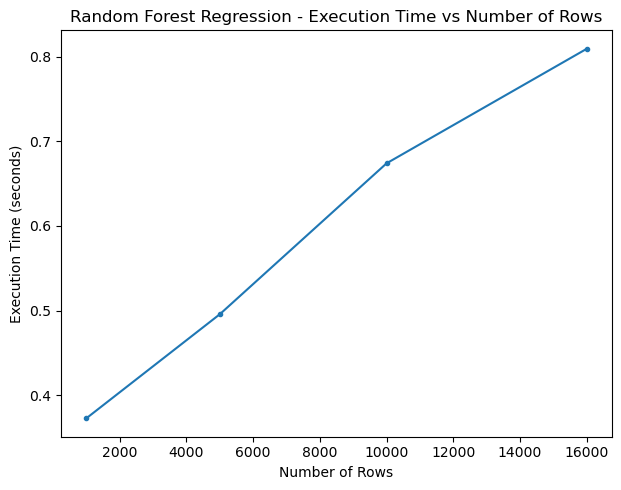

In [7]:
#random forest model
random_forest_regressor = RandomForestRegressor(featuresCol='features', labelCol='Yield_kg_per_hectare')

# Create pipelines
rf_pipeline = Pipeline(stages=[vector_assembler, random_forest_regressor])

# List of models and their names
models = [(rf_pipeline, 'Random Forest Regression')]

# Vary the number of rows for testing
num_rows_values = [1000, 5000, 10000, 16000]
rmse_values_rf = []
mae_values_rf = []
r2_values_rf = []
training_times_rf = []

for num_rows_to_read in num_rows_values:
    # Limit the number of rows to read
    sampled_data = train_df_assembled.limit(num_rows_to_read)

    for model, model_name in models:
        # Start timing
        start_time = time.time()

        # Train the model
        trained_model = model.fit(sampled_data)

        # End timing
        end_time = time.time()

        # Calculate training time
        training_time = end_time - start_time

        # Print model name and training time
        print(f'\nResults for {model_name} and {num_rows_to_read} Rows:')
        print(f'Training Time: {training_time} seconds')

        # Make predictions on the test data
        predictions = trained_model.transform(sampled_data)

        # Evaluate the model
        evaluator = RegressionEvaluator(labelCol='Yield_kg_per_hectare', predictionCol='prediction', metricName='rmse')
        rmse = evaluator.evaluate(predictions)
        print(f'Root Mean Squared Error (RMSE) on test data: {rmse}')

        # Additional evaluation metrics
        mae_evaluator = RegressionEvaluator(labelCol='Yield_kg_per_hectare', predictionCol='prediction', metricName='mae')
        mae = mae_evaluator.evaluate(predictions)
        print(f'Mean Absolute Error (MAE) on test data: {mae}')

        # R-squared (coefficient of determination)
        r2_evaluator = RegressionEvaluator(labelCol='Yield_kg_per_hectare', predictionCol='prediction', metricName='r2')
        r2 = r2_evaluator.evaluate(predictions)
        print(f'R-squared (R2) on test data: {r2}\n')

        # Store values for plotting
        if model_name == 'Random Forest Regression':
            rmse_values_rf.append(rmse)
            mae_values_rf.append(mae)
            r2_values_rf.append(r2)
            training_times_rf.append(training_time)

        # Plotting
        plt.scatter(predictions.select('Yield_kg_per_hectare').collect(), predictions.select('prediction').collect(), marker='.',color='purple')
        plt.plot(predictions.select('Yield_kg_per_hectare').collect(), predictions.select('Yield_kg_per_hectare').collect(), color='black', linewidth=2)
        plt.title(f'Actual vs Predicted for {model_name} and {num_rows_to_read} Rows')
        plt.xlabel('Actual Yield (kg per hectare)')
        plt.ylabel('Predicted Yield (kg per hectare)')
        plt.show()

# Plot Execution time vs number of rows
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(num_rows_values, training_times_rf, marker='.', label='Random Forest Regression')
plt.title('Random Forest Regression - Execution Time vs Number of Rows')
plt.xlabel('Number of Rows')
plt.ylabel('Execution Time (seconds)')


plt.tight_layout()
plt.show()